Iterasjon  0  L =  1.2777811445617648 
Iterasjon  1  L =  1.5985271477183858 
Iterasjon  2  L =  4.094068424389013 
Iterasjon  3  L =  7.906596791629051 
Iterasjon  4  L =  11.28890437853094 
Iterasjon  5  L =  13.543816462750035 
Iterasjon  6  L =  13.879216637444264 
Iterasjon  7  L =  13.793064330027818 
Iterasjon  8  L =  13.846057490576353 
Iterasjon  9  L =  14.161793331486402 
Iterasjon  10  L =  15.61198843513552 
Iterasjon  11  L =  17.60255466883731 
Iterasjon  12  L =  19.812075866932805 
Iterasjon  13  L =  22.85864726574875 
Iterasjon  14  L =  28.174643153504462 
Iterasjon  15  L =  36.1309514996542 
Iterasjon  16  L =  45.68968760286357 
Iterasjon  17  L =  46.08399800319691 
Iterasjon  18  L =  50.355147648691556 
Iterasjon  19  L =  54.57856929152108 
Iterasjon  20  L =  57.809092061838385 
Iterasjon  21  L =  60.809865451201304 
Iterasjon  22  L =  65.17411079488164 
Iterasjon  23  L =  71.7052178985618 
Iterasjon  24  L =  80.01789263058488 


c:\Users\Bruker\Documents\04_STUDIE\VitBer\TMA4320-IndMat\VitBer_indMat\prosjekt_2_utlevert_kode\layers.py:168: RuntimeWarning: divide by zero encountered in log
  q = -np.log(p)


Iterasjon  25  L =  inf 
Iterasjon  26  L =  inf 
Iterasjon  27  L =  inf 
Iterasjon  28  L =  inf 
Iterasjon  29  L =  inf 
Iterasjon  30  L =  inf 
Iterasjon  31  L =  inf 
Iterasjon  32  L =  inf 
Iterasjon  33  L =  inf 
Iterasjon  34  L =  inf 
Iterasjon  35  L =  inf 
Iterasjon  36  L =  inf 
Iterasjon  37  L =  inf 
Iterasjon  38  L =  inf 
Iterasjon  39  L =  inf 
Iterasjon  40  L =  inf 
Iterasjon  41  L =  inf 
Iterasjon  42  L =  inf 
Iterasjon  43  L =  inf 
Iterasjon  44  L =  inf 
Iterasjon  45  L =  inf 
Iterasjon  46  L =  inf 
Iterasjon  47  L =  inf 
Iterasjon  48  L =  inf 
Iterasjon  49  L =  inf 
Iterasjon  50  L =  inf 
Iterasjon  51  L =  inf 
Iterasjon  52  L =  inf 
Iterasjon  53  L =  inf 
Iterasjon  54  L =  inf 
Iterasjon  55  L =  inf 
Iterasjon  56  L =  inf 
Iterasjon  57  L =  inf 
Iterasjon  58  L =  inf 
Iterasjon  59  L =  inf 
Iterasjon  60  L =  inf 
Iterasjon  61  L =  inf 
Iterasjon  62  L =  inf 
Iterasjon  63  L =  inf 
Iterasjon  64  L =  inf 


c:\Users\Bruker\Documents\04_STUDIE\VitBer\TMA4320-IndMat\VitBer_indMat\prosjekt_2_utlevert_kode\layers.py:168: RuntimeWarning: divide by zero encountered in log
  q = -np.log(p)


Iterasjon  59  L =  inf 
Iterasjon  60  L =  inf 
Iterasjon  61  L =  inf 
Iterasjon  62  L =  inf 
Iterasjon  63  L =  inf 
Iterasjon  64  L =  inf 
Iterasjon  65  L =  inf 
Iterasjon  66  L =  inf 
Iterasjon  67  L =  inf 
Iterasjon  68  L =  inf 
Iterasjon  69  L =  inf 
Iterasjon  70  L =  inf 
Iterasjon  71  L =  inf 
Iterasjon  72  L =  inf 
Iterasjon  73  L =  inf 
Iterasjon  74  L =  inf 
Iterasjon  75  L =  inf 
Iterasjon  76  L =  inf 
Iterasjon  77  L =  inf 
Iterasjon  78  L =  inf 
Iterasjon  79  L =  inf 
Iterasjon  80  L =  inf 
Iterasjon  81  L =  inf 
Iterasjon  82  L =  inf 
Iterasjon  83  L =  inf 
Iterasjon  84  L =  inf 
Iterasjon  85  L =  inf 
Iterasjon  86  L =  inf 
Iterasjon  87  L =  inf 
Iterasjon  88  L =  inf 
Iterasjon  89  L =  inf 
Iterasjon  90  L =  inf 
Iterasjon  91  L =  inf 
Iterasjon  92  L =  inf 
Iterasjon  93  L =  inf 
Iterasjon  94  L =  inf 
Iterasjon  95  L =  inf 
Iterasjon  96  L =  inf 
Iterasjon  97  L =  inf 
Iterasjon  98  L =  inf 


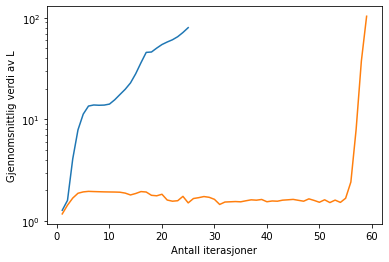

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from training_algorithm import TrainingAlgorithm

nn_adding, mean_losses_adding = TrainingAlgorithm(1)

n = np.arange(1, len(mean_losses_adding)+1)

plt.xlabel('Antall iterasjoner')
plt.ylabel('Gjennomsnittlig verdi av L')
plt.yscale("log")
plt.plot(n, mean_losses_adding)

nn_adding, mean_losses_adding = TrainingAlgorithm(0)

n = np.arange(1, len(mean_losses_adding)+1)

plt.xlabel('Antall iterasjoner')
plt.ylabel('Gjennomsnittlig verdi av L')
plt.yscale("log")
plt.plot(n, mean_losses_adding)

Under trening av algoritmen opplever vi to større feil ved minimering av Loss-funksjonen:\
**Feil 1:** Både step_Adam og step_gd gir en økning i verdien til Loss-funksjonen. Step_Adam varierer før den divergerer, til forskjell fra step_gd som er helt lineær og svakt økende.\
**Feil 2:** Bruk av step_Adam gir "RuntimeWarning: divide by zero encountered in log q = -np.log(p)" for attention forward. 

Under debuggingen  har vi utforsket følgende hypoteser: 
1) Matriseelementer i p i attention forward er lik null, og np.log(p) gir feilmenldinger da logaritmen til 0 ikke eksisterer. Det er flere grunner til at p kan bli lik null, blant dem:
    - self.Y = onehot(y,m) blir null: dersom onehot ikke fungerer som den skal og og ikke leverer verdier lik 1 vil den kunne gi en null-matrise for self.Y = onehot(y,m). Vi sjekket derfor max-verdien i hver kolonne til onehot-matrisen og fikk at samtlige hadde en verdi 1. Onehot fungerer derfor tilsynelatende som den skal. 
    - self.Y_hat = Z[:,:,-r:] blir null: dersom Z = nn.forward(X) ikke fungerer slik den skal vil den kunne gi ut en Z som blir enten null eller veldig liten. Til å teste dette printet vi retur-verdien til hvert lag i forward. Vi oppdager at flere verdier i softmax divergerer mot null men tester samtidig kollonnesummene og ser at disse er lik 1 (eller tilnærmet lik +-10**-8). Siden Softmax er en sannsynlighetsfordeling kan det stemme at flere av elementene har sannsynligheter som er nærmest lik null, og siden kollonnesummene stemmer finner vi ingen åpenbare kilder til feil for Z.
2) Dimensjonsfeil 
    - dersom slizingen av Z ikke er gjort riktig og gir feil self.Y_hat = Z kan dette være en kilde til feil. Her sjekket vi derfor at både Y_hat og Y har like dimensjoner ("legge inn dim her")
    - feil bruk av einsum vil kunne gi feile dimensjoner som kan gå utover f.eks np.sum()-funksjonene som behandler sannsynlighetsfordelingene i forward pass eller på andre måter gjøre at informasjon går tapt i nettverket. Vi printet "shapen" til matrisene og forsikret oss om at de gir ut riktige dimensjoner. 
    - sjekket axis
3) Feil i Adam (løser ikke problemet for step_gd)
    - hvada?
4) Training algorithm




Iterasjon  0  L =  2.3083778123221554 
Iterasjon  1  L =  2.3083905701260368 
Iterasjon  2  L =  2.308403329444613 
Iterasjon  3  L =  2.308416090281731 
Iterasjon  4  L =  2.3084288526578702 
Iterasjon  5  L =  2.308441618991911 
Iterasjon  6  L =  2.3084544042827053 
Iterasjon  7  L =  2.3084671953293183 
Iterasjon  8  L =  2.3084799881376994 
Iterasjon  9  L =  2.308492782859656 
Iterasjon  10  L =  2.308505578129202 
Iterasjon  11  L =  2.3085183744581665 
Iterasjon  12  L =  2.308531172347815 
Iterasjon  13  L =  2.308543971797592 
Iterasjon  14  L =  2.3085567719429987 
Iterasjon  15  L =  2.308569574983344 
Iterasjon  16  L =  2.3085823832931416 
Iterasjon  17  L =  2.3085951933231943 
Iterasjon  18  L =  2.308608004937965 
Iterasjon  19  L =  2.3086208181412653 
Iterasjon  20  L =  2.308633632936906 
Iterasjon  21  L =  2.308646449328691 
Iterasjon  22  L =  2.308659267320426 
Iterasjon  23  L =  2.308672086915908 
Iterasjon  24  L =  2.308684907868142 
Iterasjon  25  L =  2.30

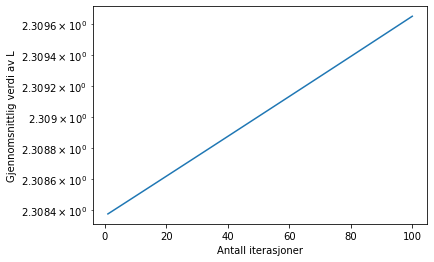

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from training_algorithm import TrainingAlgorithm

nn_adding, mean_losses_adding = TrainingAlgorithm(0)

n = np.arange(1, len(mean_losses_adding)+1)

plt.xlabel('Antall iterasjoner')
plt.ylabel('Gjennomsnittlig verdi av L')
plt.yscale("log")
plt.plot(n, mean_losses_adding)